In [1]:
# Google API dashboard:
# https://console.cloud.google.com/apis/dashboard?project=my-project-1543901530556&consoleReturnUrl=https:%2F%2Fcloud.google.com%2Fmaps-platform%2F%3Fapis%3Dmaps%26project%3Dmy-project-1543901530556&consoleUI=CLOUD&duration=PT1H
# Google elevation request guide:
# https://developers.google.com/maps/documentation/elevation/intro#ElevationRequests

In [2]:
# Import all packages and helpter functions
import sys
sys.path.append('../')
from utils import *

In [3]:
edge = pd.read_csv(raw_path + '5c_edges.csv')
print(edge.shape)
edge.head(3)

(1743, 14)


,access,geometry,highway,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,u,v
0,NaN,"LINESTRING (-117.7037585 34.1049333, -117.7037...",footway,0,NaN,35.446,NaN,NaN,False,551541821,NaN,NaN,5326481411,5326481407
1,NaN,"LINESTRING (-117.7037585 34.1049333, -117.7037...",footway,1,NaN,16.388,NaN,NaN,False,551541821,NaN,NaN,5326481411,5326481407
2,NaN,"LINESTRING (-117.7037585 34.1049333, -117.7037...",footway,0,NaN,92.226,NaN,NaN,False,"[556348964, 551541822]",NaN,NaN,5326481411,5366824714


We observe that edges are not simple line segments. It could have several nodes in there, and has different shapes, e.g. arcs or lines.

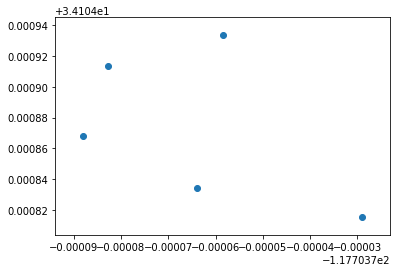

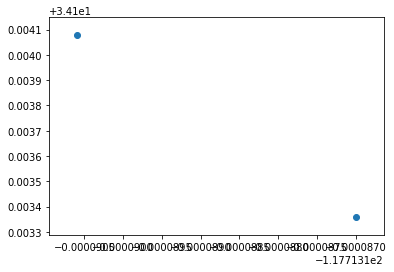

In [4]:
visualize_path(edge, 1)
visualize_path(edge, 100)

In [5]:
process_edge_csv_rows(edge, 1)

([-117.7037585, -117.7037827, -117.703788, -117.7037639],
 [-117.7037827, -117.703788, -117.7037639, -117.703729],
 [34.1049333, 34.1049133, 34.1048678, 34.1048345],
 [34.1049133, 34.1048678, 34.1048345, 34.1048156],
 ['footway', 'footway', 'footway', 'footway'],
 [False, False, False, False],
 [1, 1, 1, 1])

In [6]:
clean_edge = defaultdict(list)
for idx in edge.index:
    y_start, y_end, x_start, x_end, highway, oneway, edge_index = process_edge_csv_rows(edge, idx)
    clean_edge['y_start'] += y_start
    clean_edge['y_end'] += y_end
    clean_edge['x_start'] += x_start
    clean_edge['x_end'] += x_end
    clean_edge['highway'] += highway
    clean_edge['oneway'] += oneway
    clean_edge['edge_index'] += edge_index
clean_edge = pd.DataFrame(clean_edge)
clean_edge.head()

,y_start,y_end,x_start,x_end,highway,oneway,edge_index
0,-117.703759,-117.703734,34.104933,34.104949,footway,False,0
1,-117.703734,-117.703689,34.104949,34.104957,footway,False,0
2,-117.703689,-117.703646,34.104957,34.104950,footway,False,0
3,-117.703646,-117.703616,34.104950,34.104913,footway,False,0
4,-117.703616,-117.703603,34.104913,34.104876,footway,False,0


count    4033.000000
mean       19.450305
std        29.686560
min         0.267727
25%         4.457312
50%         7.991341
75%        20.647344
max       254.867102
Name: length, dtype: float64


/Users/zihaoxu/ENTER/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/zihaoxu/ENTER/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


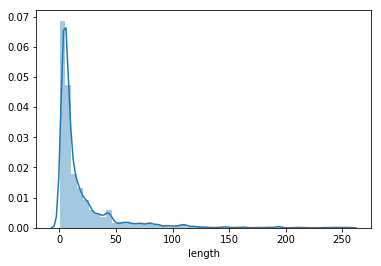

In [7]:
path_lengths = [get_path_length(clean_edge, i) for i in range(len(clean_edge))]
clean_edge['length'] = path_lengths
print(clean_edge['length'].describe())
sns.distplot(clean_edge['length'])

In [8]:
seg_length = 5
print("Total number of edges less than", str(seg_length), "m:", sum([l<seg_length for l in clean_edge['length']]))
print("Total number of nodes in the new graph (overestimate):", sum([l//seg_length+1 for l in clean_edge['length']]))

Total number of edges less than 5 m: 1271
Total number of nodes in the new graph (overestimate): 17579.0


In [9]:
break_up_edges_to_nodes(clean_edge, 14, seg_length)

,y_start,y_end,x_start,x_end,highway,oneway,edge_index,length
0,-117.703761,-117.703705,34.105117,34.105149,footway,False,2,7.256644
1,-117.703705,-117.703648,34.105149,34.105182,footway,False,2,7.256644


In [13]:
for idx in clean_edge.index:
    if idx == 0:
        output = break_up_edges_to_nodes(clean_edge, idx, seg_length)
    else:
        output = pd.concat([output, break_up_edges_to_nodes(clean_edge, idx, seg_length)])
print(output.shape)
output.head()

(14817, 8)


,y_start,y_end,x_start,x_end,highway,oneway,edge_index,length
0,-117.703759,-117.703734,34.104933,34.104949,footway,False,0,3.189174
1,-117.703734,-117.703689,34.104949,34.104957,footway,False,0,5.133640
2,-117.703689,-117.703646,34.104957,34.104950,footway,False,0,4.818226
3,-117.703646,-117.703616,34.104950,34.104913,footway,False,0,5.235189
4,-117.703616,-117.703603,34.104913,34.104876,footway,False,0,4.451838


Observe that after the transformation, the path length are all under 10, mostly concentrated around 5 meters.

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/zihaoxu/ENTER/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


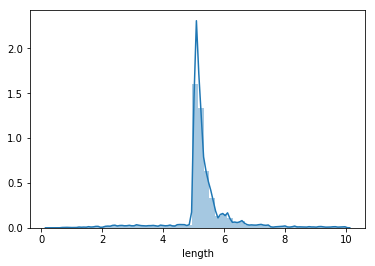

In [14]:
sns.distplot(output['length'])

In [15]:
output.to_csv(mst_path + 'clean_edge.csv', index = None)